Using [Ocean Parcels](https://oceanparcels.org) to track the surface movement of contaminants. 
Original code written by Bec Gordon & Javier Porobic, CSIRO, and code requires additional python libraries stored in /Parcel_Utils/ within the [SSAM Ocean Parcels Repo](https://bitbucket.csiro.au/users/por07g/repos/ssam_oceanparcels/browse)

In [1]:
import sys
import os
import math
from parcels import AdvectionRK4, VectorField, Variable
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field
import numpy as np
from datetime import timedelta as delta
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times
from util.parse_wildcards import parse_wildcards

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_e0783373-41a3-4c79-9813-a1ec083fcfec.so


Select the location of interest, which is specified by a shapefile.

In [2]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",}
print("\nScenario running  :", scenario[file_id], sep = " ")

 1



Scenario running  : 5b_Turn_Point_Diluted_bitumen


In [3]:
#Kernels
def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this need to be add to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2
            
def BeachTesting(particle, fieldset, time):
    """ Testing if particles are on land. if 'yes' particle will be removed"""
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        #print(u, v)
        if u == 0 and v == 0:
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(-1.0 * dt/field_decay_value)
    particle.decay_value = particle.decay_value * decay

In [4]:
# Data Paths
currents = '/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/'
winds = '/ocean/rlovindeer/Atlantis/Physics/Wind/'
sea_grid = '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc'
air_grid = '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'

In [5]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
u_data_path = currents + '2018-01*URaw_variables.nc'
v_data_path = currents + '2018-01*VRaw_variables.nc'
u_current = parse_wildcards(u_data_path, 'u')
v_current = parse_wildcards(v_data_path, 'v')

filenames = {'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
             'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
print('creating from_nemo')
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
print('creating from_nemo done')

fieldset.add_constant('decay', 1.0 * 3600.0)
print('add_constant decay')

creating from_nemo


creating from_nemo done
add_constant decay


In [16]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_data_path = winds + '*_Wind_variables.nc'
wind_paths = parse_wildcards(wind_data_path, 'u')
#wind_paths = ['/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-01_UWind_variables.nc','/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-02_UWind_variables.nc']
wind_filenames = {'lon': air_grid,'lat': air_grid,'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

print(wind_filenames)
print(wind_dimensions)

{'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc', 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc', 'data': ['/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-01_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-03_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-05_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-07_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-09_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-11_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-13_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-15_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-17_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-19_Wind_variables.nc', '/ocean/rlovindeer/Atlantis/Physics/Wind/2018-01-21_Wind_variables.nc', '/ocean/rlovin

In [17]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [18]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [19]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 1
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [22]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 100
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario[file_id] + ".shp"
release_depth = -0.1
release_start_time = '2018-01-01'  ## winter start on December, Summer Jul - Aug  ## ask Susan about when to do simulation
release_end_time = '2018-01-02'
release_start_time = np.datetime64(release_start_time)
release_end_time = np.datetime64(release_end_time)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time)
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth)

print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle)
beaching_kernel = pset.Kernel(BeachTesting)
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4)

# Adding to the main kernel
my_kernel = AdvectionRK4 + decay_kernel + ForcingWind_kernel + beaching_kernel

output_file_name = scenario[file_id] + '_oil_disperse.nc'
print(output_file_name)

setting up particles
-1800.0
100
100
Using shapefile /ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/5b_Turn_Point_Diluted_bitumen.shp
Number of sites :  1
Up to 0 of 1
80
100
Sucessfully seeded particles

num_attempts = 2
[-123.29342181743614, -123.29308906571126, -123.29331391769186, -123.29342967807801, -123.29367213484532, -123.29322765621787, -123.29364427002147, -123.29273589844243, -123.29375256140635, -123.29293599436784, -123.2934616546045, -123.29338335532181, -123.29266825116741, -123.2943451858446, -123.2928542047529, -123.2929631309421, -123.29277942014751, -123.29292112731557, -123.29359648571949, -123.29295838609143, -123.29428289559226, -123.29323960240134, -123.29263010660989, -123.2934757478005, -123.29369012056402, -123.2939903332198, -123.29297097706512, -123.29360714377957, -123.29338257654626, -123.29448186484314, -123.29328417344985, -123.29329525299856, -123.29328557645024, -123.29263194828697, -123.29315580384579, -123.29380042864285, -12

In [23]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove '5b_Turn_Point_Diluted_bitumen_oil_disperse.nc': No such file or directory


INFO: Temporary output files are stored in out-ULUFKJCK.
INFO: You can use "parcels_convert_npydir_to_netcdf out-ULUFKJCK" to convert these to a NetCDF file during the run.
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:24:20 Time:  0:24:20
/home/rlovindeer/conda_envs/parcels-dev/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


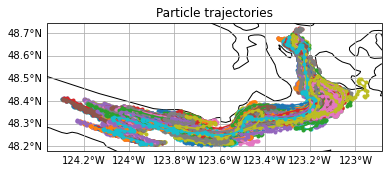

particle trajectories completed


In [24]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*6),   # the total length of the run
             dt = timedelta(minutes = 60),      # the timestep of the kernel
             output_file = output_file)  # the file name and the time step of the outputs
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')